In [1]:
import cv2
import numpy as np

def generate_tissue_mask(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

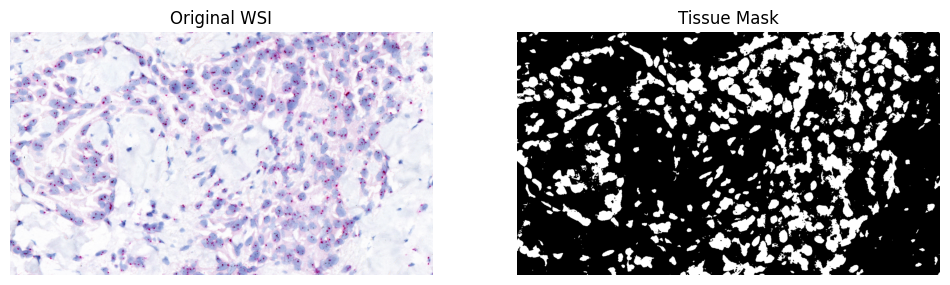

In [2]:
import matplotlib.pyplot as plt

img = cv2.imread("/kaggle/input/her2-sish-dataset/Non-Amplified Samples/168136629.png")
mask = generate_tissue_mask(img)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Original WSI")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Tissue Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

In [3]:
import os
from tqdm import tqdm

PATCH_SIZE = 224
STRIDE = 224
TISSUE_THRESHOLD = 0.7

def extract_patches(img, mask, save_dir, slide_id):
    h, w, _ = img.shape

    for y in range(0, h - PATCH_SIZE + 1, STRIDE):
        for x in range(0, w - PATCH_SIZE + 1, STRIDE):
            patch = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            mask_patch = mask[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

            tissue_ratio = np.sum(mask_patch > 0) / (PATCH_SIZE * PATCH_SIZE)

            if tissue_ratio >= TISSUE_THRESHOLD:
                patch_name = f"{slide_id}_x{x}_y{y}.png"
                cv2.imwrite(os.path.join(save_dir, patch_name), patch)

def process_wsi(image_path, label_name, output_root):
    slide_id = os.path.splitext(os.path.basename(image_path))[0]
    img = cv2.imread(image_path)
    mask = generate_tissue_mask(img)

    save_dir = os.path.join(output_root, label_name)
    os.makedirs(save_dir, exist_ok=True)

    extract_patches(img, mask, save_dir, slide_id)

In [4]:
DATASET_ROOT = "/kaggle/input/her2-sish-dataset"
PATCH_ROOT = "/kaggle/working/patches"

classes = {
    "Amplified Samples": "Amplified",
    "Non-Amplified Samples": "Non_Amplified",
    "ROI_Normal": "ROI_Normal"
}

for folder, label in classes.items():
    folder_path = os.path.join(DATASET_ROOT, folder)

    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith((".png", ".jpg")):
            process_wsi(
                os.path.join(folder_path, img_name),
                label,
                PATCH_ROOT
            )

In [5]:
!ls /kaggle/working/patches/Amplified | head

168138400_x896_y2464.png
168139738_x1120_y224.png
168139738_x1344_y224.png
168139738_x1792_y1568.png
168139738_x672_y0.png
168139881_x3808_y672.png
169262605_x1792_y1792.png
169262605_x1792_y2464.png
169262605_x2016_y1792.png
169262605_x896_y2240.png
ls: write error: Broken pipe


In [6]:
# Root Dataset count
print("WSI count per class:")
for folder in os.listdir(DATASET_ROOT):
    folder_path = os.path.join(DATASET_ROOT, folder)
    
    if os.path.isdir(folder_path):
        count = sum(
            1 for f in os.listdir(folder_path)
            if f.lower().endswith((".png", ".jpg"))
        )
        print(f"{folder}: {count}")

# Patch Data count
print("\nPatch count per class:")
for folder in os.listdir(PATCH_ROOT):
    folder_path = os.path.join(PATCH_ROOT, folder)
    
    if os.path.isdir(folder_path):
        count = sum(
            1 for f in os.listdir(folder_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        )
        print(f"{folder}: {count}")

WSI count per class:
Amplified Samples: 113
ROI_Normal: 300
Non-Amplified Samples: 124

Patch count per class:
Non_Amplified: 734
ROI_Normal: 270
Amplified: 696


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

BATCH_SIZE = 16
IMG_SIZE = (224, 224)
SEED = 123

# Train = 70%
train_ds = tf.keras.utils.image_dataset_from_directory(
    PATCH_ROOT,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

# Temp = 30% (will become val + test)
temp_ds = tf.keras.utils.image_dataset_from_directory(
    PATCH_ROOT,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

class_names = train_ds.class_names
print("Class names:", class_names)

2025-12-26 12:20:43.175500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766751643.358782      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766751643.413814      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766751643.866093      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766751643.866124      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766751643.866127      55 computation_placer.cc:177] computation placer alr

Found 1700 files belonging to 3 classes.
Using 1190 files for training.


I0000 00:00:1766751656.137721      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1700 files belonging to 3 classes.
Using 510 files for validation.
Class names: ['Amplified', 'Non_Amplified', 'ROI_Normal']


In [8]:
# Number of batches in temp dataset
temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()

# Split evenly
val_batches = temp_batches // 2
test_batches = temp_batches - val_batches

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)


AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

In [9]:
from sklearn.utils.class_weight import compute_class_weight

y_train = []

for _, labels in train_ds:
    y_train.extend(labels.numpy())

y_train = np.array(y_train)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.8078750848608283), 1: np.float64(0.7933333333333333), 2: np.float64(1.9932998324958124)}


In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.25),
    tf.keras.layers.GaussianNoise(0.05),
])

In [12]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D,
    Activation, Dense, Multiply, Add, Dropout
)

In [13]:
from sklearn.ensemble import IsolationForest
from scipy.stats.mstats import winsorize

# --- 1. Provided Reference Functions ---

def _iso_winsor_numpy_flat(x_batch_np, contamination=0.05, win_limit=0.05, random_state=42):
    """
    Processes a (Batch, Features) array: fits Isolation Forest, 
    identifies outliers, and winsorizes only those outlier samples.
    """
    if hasattr(x_batch_np, "numpy"):  
        x_batch_np = x_batch_np.numpy()
    x_batch_np = np.asarray(x_batch_np, dtype=np.float32)

    B, F = x_batch_np.shape

    # Contamination 0.05 = 95% normal range
    clf = IsolationForest(contamination=contamination, random_state=random_state)
    preds = clf.fit_predict(x_batch_np)  # 1=inlier, -1=outlier

    out = x_batch_np.copy()
    for i in range(B):
        if preds[i] == -1:
            # Apply winsorization to the outlier row
            w = winsorize(out[i], limits=[win_limit, win_limit])
            out[i] = np.asarray(w, dtype=np.float32)

    return out

def isolation_winsor_flattened_tf(contamination=0.05, win_limit=0.05, random_state=42):
    """
    Wraps the numpy function into a TensorFlow-compatible Op with 
    an identity gradient (allowing backprop to pass through).
    """
    def layer_op(x2d):
        @tf.custom_gradient
        def _op(x_in):
            y = tf.py_function(
                func=lambda z: _iso_winsor_numpy_flat(
                    z,
                    contamination=contamination,
                    win_limit=win_limit,
                    random_state=random_state,
                ),
                inp=[x_in],
                Tout=tf.float32
            )
            y.set_shape(x_in.shape) 

            def grad(dy):
                return dy  # Identity pass-through
            return y, grad
        return _op(x2d)
    return layer_op


In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models

def build_vgg19_robust(
    input_shape=(224, 224, 3),
    num_classes=3
):
    inputs = layers.Input(shape=input_shape)

    # Preprocessing
    # Ensure data_augmentation is defined in your scope
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # VGG19 Base
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    base_model.trainable = False
    x = base_model.output

    # 1. Flattening / Pooling stage
    x = layers.GlobalAveragePooling2D()(x)

    # 2. Isolation Forest + Winsorization Lambda (Replaces Dropout)
    # Applied AFTER flattening but BEFORE the dense classifier
    x = layers.Lambda(
        isolation_winsor_flattened_tf(contamination=0.05, win_limit=0.05),
        name="robust_outlier_filter"
    )(x)

    # 3. Dense Classifier Section
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

In [15]:
model = build_vgg19_robust(input_shape=(224,224,3), num_classes=3)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=6,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


I0000 00:00:1766751723.345461     140 cuda_dnn.cc:529] Loaded cuDNN version 91002


75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 246ms/step - accuracy: 0.4554 - loss: 1.0230 - val_accuracy: 0.5352 - val_loss: 0.9215 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 230ms/step - accuracy: 0.5398 - loss: 0.9464 - val_accuracy: 0.5430 - val_loss: 0.9145 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 231ms/step - accuracy: 0.4767 - loss: 0.9515 - val_accuracy: 0.5625 - val_loss: 0.8663 - learning_rate: 1.0000e-04
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - accuracy: 0.5469 - loss: 0.9113 - val_accuracy: 0.6211 - val_loss: 0.8514 - learning_rate: 1.0000e-04
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - accuracy: 0.5615 - loss: 0.9043 - val_accuracy: 0.6055 - val_loss: 0.8263 - learning_rate: 1.0000e-04
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 235ms/step - accuracy: 0.5816 - loss: 0.8730 - val_accuracy: 0.6211 - val_loss: 0.8125 - learning_rate: 1.0000e-04
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 233ms/step - accuracy: 0.56

In [18]:
for layer in model.layers:
    if "block5" in layer.name:
        layer.trainable = True
    else:
        # We keep the custom Lambda and Dense layers trainable for fine-tuning
        if not isinstance(layer, layers.Dense) and "lambda" not in layer.name:
            layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    # CHANGED: Ensure this matches Phase 1
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

fine_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.6093 - loss: 0.8191 - val_accuracy: 0.6797 - val_loss: 0.6973 - learning_rate: 1.0000e-05
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step - accuracy: 0.6412 - loss: 0.7521 - val_accuracy: 0.7070 - val_loss: 0.6599 - learning_rate: 1.0000e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.6512 - loss: 0.7615 - val_accuracy: 0.7188 - val_loss: 0.6364 - learning_rate: 1.0000e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.6627 - loss: 0.7109 - val_accuracy: 0.7188 - val_loss: 0.6429 - learning_rate: 1.0000e-05
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.6787 - loss: 0.7151 - val_accuracy: 0.7227 - val_loss: 0.6369 - learning_rate: 1.0000e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.7093 - loss: 0.6468 - val_accuracy: 0.7734 - val_loss: 0.5596 - learning_rate: 1.0000e-05
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - acc

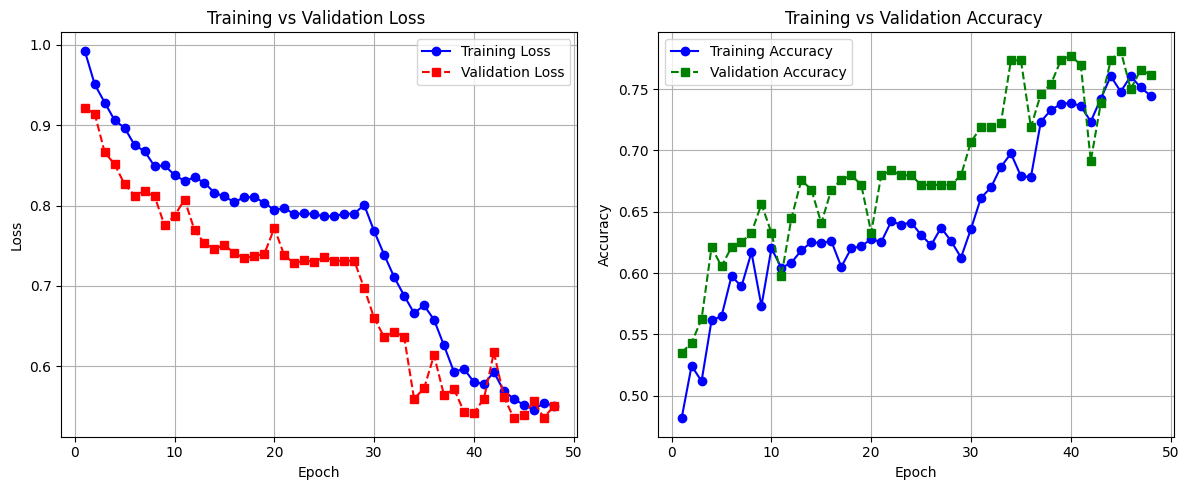

In [20]:
import matplotlib.pyplot as plt

def plot_train_val_curves(history, title_suffix=''):
    train_losses = history.history['loss'] + fine_history.history['loss']
    val_losses   = history.history['val_loss'] + fine_history.history['val_loss']
    train_acc    = history.history['accuracy'] + fine_history.history['accuracy']
    val_acc      = history.history['val_accuracy'] + fine_history.history['val_accuracy']
    
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r--s', label='Validation Loss')
    plt.title(f'Training vs Validation Loss {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g--s', label='Validation Accuracy')
    plt.title(f'Training vs Validation Accuracy {title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_train_val_curves(history)

In [21]:
from sklearn.metrics import classification_report

y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
               precision    recall  f1-score   support

    Amplified       0.75      0.69      0.72       108
Non_Amplified       0.72      0.78      0.75       108
   ROI_Normal       0.86      0.84      0.85        38

     accuracy                           0.75       254
    macro avg       0.78      0.77      0.77       254
 weighted avg       0.75      0.75      0.75   

<Figure size 700x600 with 0 Axes>

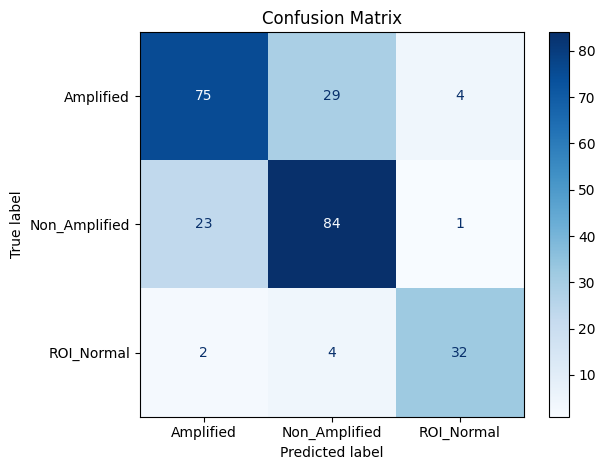

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(7, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()